In [1]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal, norm
from scipy.spatial.distance import cdist
from scipy.special import kl_div, gamma, gammaln, digamma
from scipy.stats import dirichlet
import itertools
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

# The ball own force is a GP with a squared exponential kernel

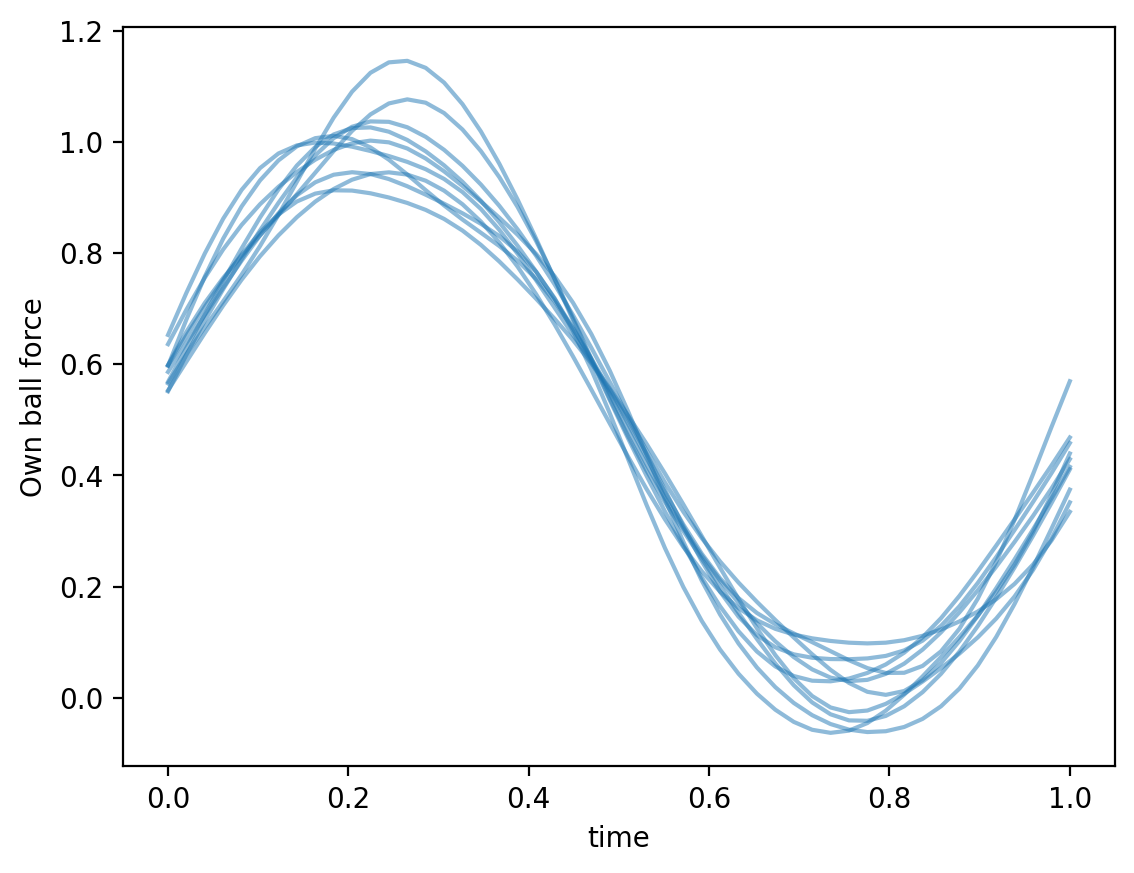

In [3]:
x = np.linspace(0, 1.0, 50)
mu = 0.5 + 0.5*np.cos(6*(x + 5))

alpha = 0.05
length = 0.1

x2d = x.reshape((-1, 1))
sigma = alpha**2 * np.exp(-0.5 * cdist(x2d, x2d, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)

n_sample = 10
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Own ball force");

# The effect of pushing the ball is a GP with a squared exponential kernel

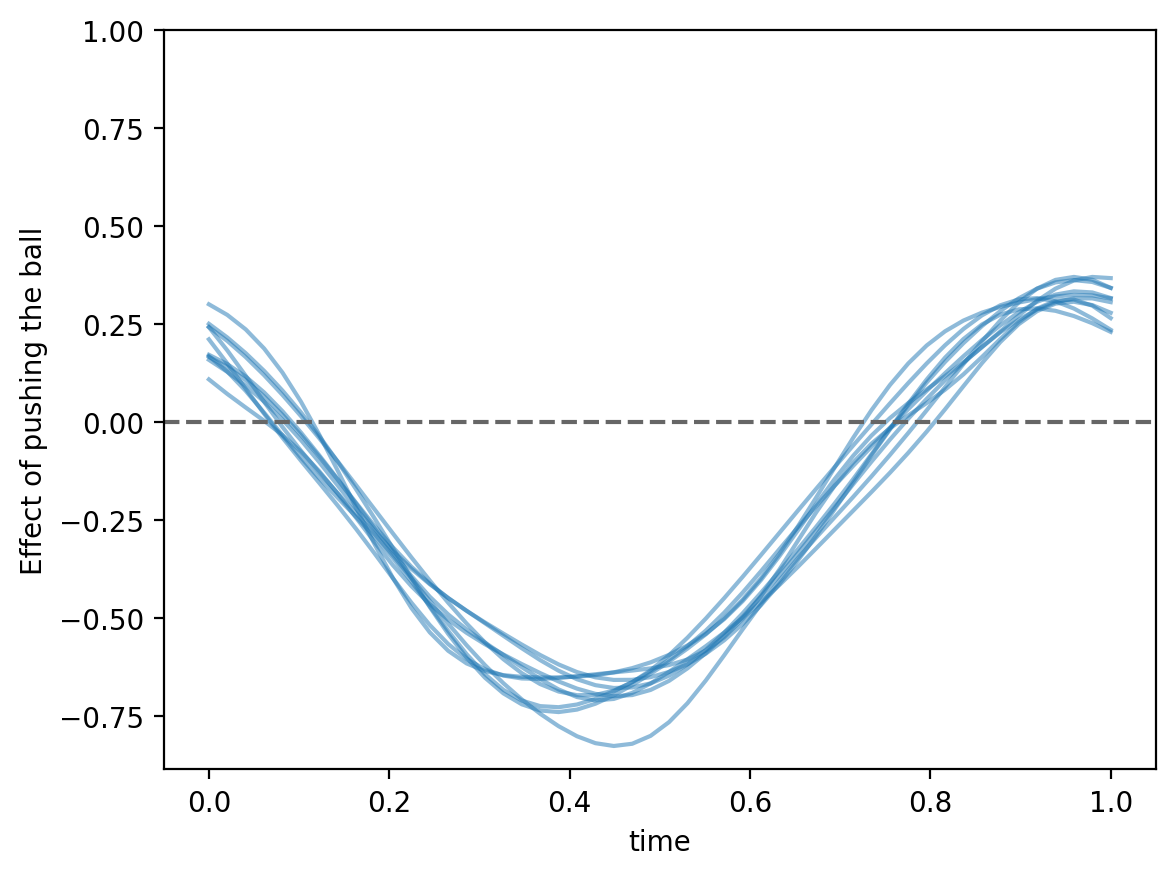

In [4]:
x = np.linspace(0, 1.0, 50).reshape((-1, 1))
mu = - 0.2 + 0.5*np.cos(6*(np.squeeze(x) - 2))

alpha = 0.05
length = 0.1

sigma = alpha**2 * np.exp(-0.5 * cdist(x, x, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Effect of pushing the ball")
ax.set_ylim(None, 1);
ax.axhline(y=0.0, ls="--", color="0.4");

# Running the ball environment

In [5]:
class Ball:
    def __init__(self, n_step):
        
        self.state = np.zeros(2)
        
        self.n_step = n_step
        self.x = np.linspace(0, 1.0, self.n_step)
        
        self.min_position, self.max_position = 0.0, 200.0
        self.max_speed = 10.0 
        
        self.friction_factor = 0.5
        
        self.own_force = None
        self.action_effect = None
        self.current_step = None

    @staticmethod
    def square_exponential_kernel(x, alpha, length):
        return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)
    
    def sample_action_effect(self):
        
        x = self.x
        mu = - 0.2 + 0.5*np.cos(6*(x - 2))
        alpha = 0.05
        length = 0.1 
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)
    
    def sample_own_force(self):
        
        x = self.x
        mu = 0.5 + 0.5*np.cos(6*(x + 5))
        alpha = 0.05
        length = 0.1
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)

    def step(self, action: int):

        position, velocity = self.state

        velocity -= self.friction_factor * velocity
        velocity += self.action_effect[self.current_step]*action
        velocity += self.own_force[self.current_step]
        
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)

        dt = (1./self.n_step)
        position += dt*velocity
        position = np.clip(position, self.min_position, self.max_position)
        
        self.state = position, velocity
        self.current_step += 1
        if self.current_step > self.n_step:
            raise ValueError("This wasn't supposed to be a step")
            
        return self.state
        
    def reset(self, seed=None):
                    
        if seed is not None:
            np.random.seed(seed)
            
        self.own_force = self.sample_own_force()
        self.action_effect = self.sample_action_effect()
        self.current_step = 0
        

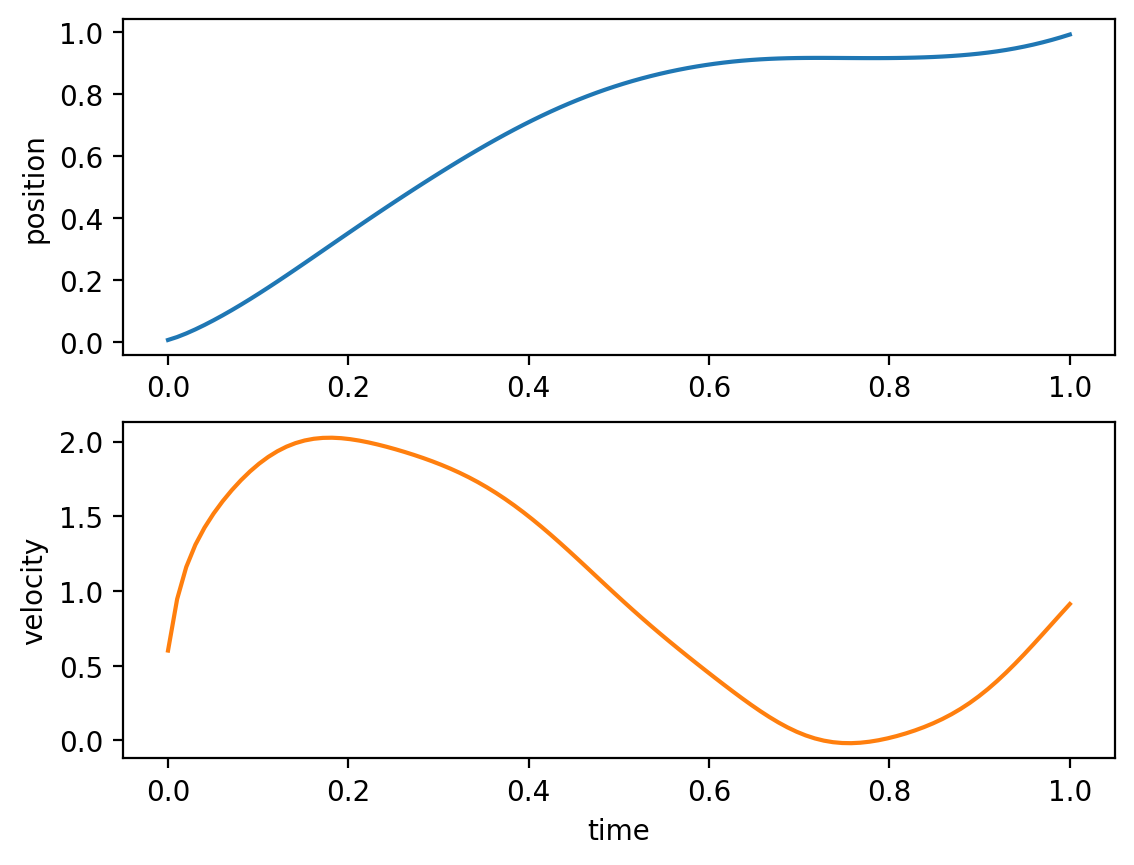

In [6]:
n_step = 100
ball = Ball(n_step)
ball.reset(seed=123456)
hist_pos, hist_vel = [], []
for i in range(n_step):
    pos, vel = ball.step(action=0)
    hist_pos.append(pos)
    hist_vel.append(vel)

_, axes = plt.subplots(nrows=2)
x = np.linspace(0, 1, n_step)
axes[0].plot(x, hist_pos)
axes[0].set_ylabel("position")
axes[1].plot(x, hist_vel, color="C1")
axes[1].set_ylabel("velocity")
axes[1].set_xlabel("time");

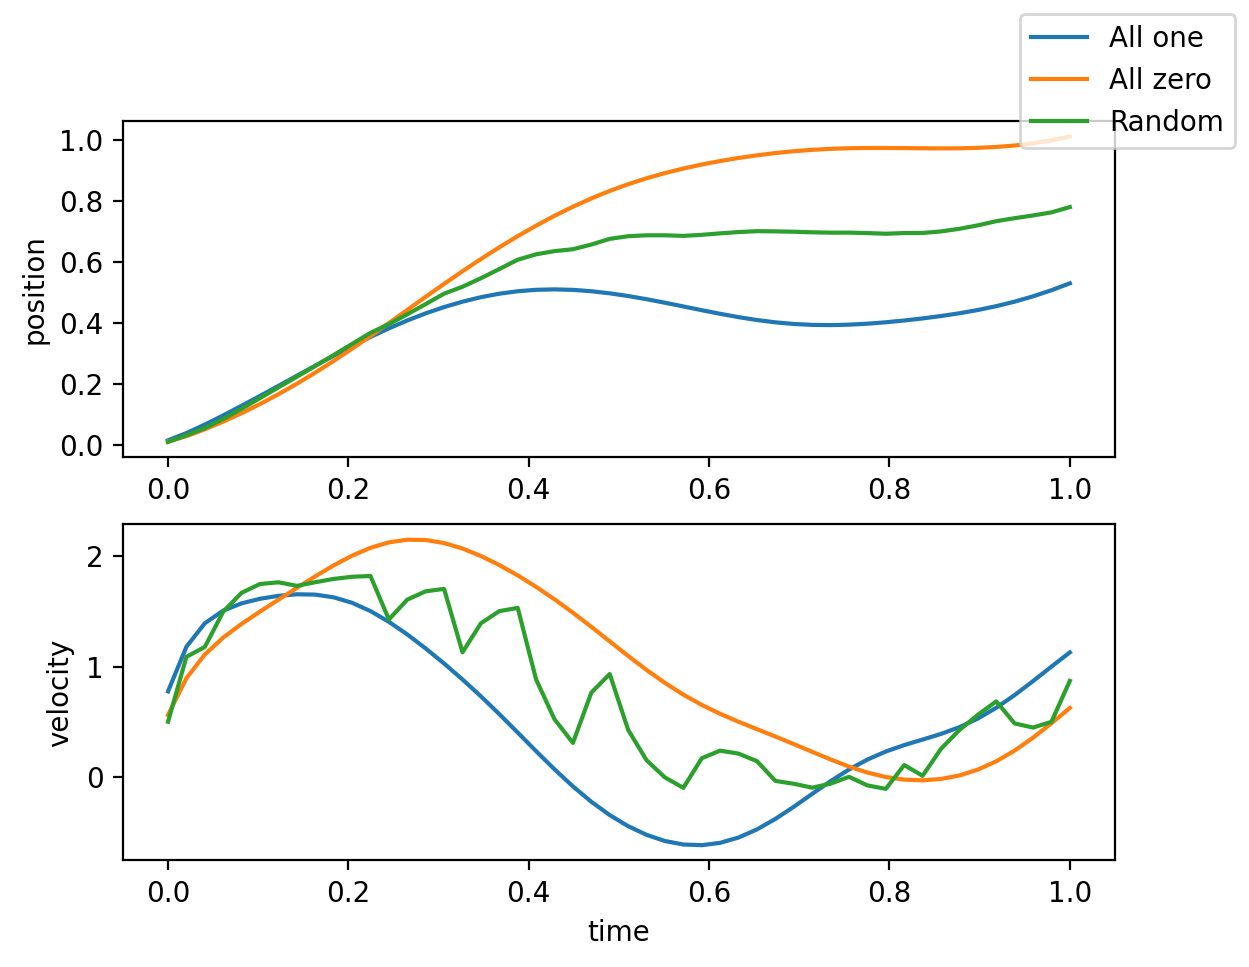

In [7]:
n_step = 50
all_hist_pos = []
all_hist_vel = []

policies = "all-one", "all-zero", "random"

for policy in policies:
    
    ball = Ball(n_step)
    ball.reset()
    hist_pos, hist_vel = [], []
    for i in range(n_step):
        if policy == "all-one":
            action = 1
        elif policy == "all-zero":
            action = 0
        elif policy == "random":
            action = np.random.choice([0, 1])
        else:
            raise ValueError
        pos, vel = ball.step(action=action)
        hist_pos.append(pos)
        hist_vel.append(vel)
        
    all_hist_pos.append(hist_pos)
    all_hist_vel.append(hist_vel)

fig, axes = plt.subplots(nrows=2)
for i in range(len(policies)):
    label = policies[i].replace("-", " ").capitalize()
    pos = all_hist_pos[i]
    vel = all_hist_vel[i]
    x = np.linspace(0, 1, n_step)
    axes[0].plot(x, pos, color=f"C{i}", label=label)
    axes[1].plot(x, vel, color=f"C{i}")
    axes[0].set_ylabel("position")
    axes[1].set_ylabel("velocity");
    axes[1].set_xlabel("time");
    
    
fig.legend();

# Moving to a discrete world

In [68]:
def square_exponential_kernel(x, alpha, length):
    return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)

def sample_action_effect(t, size=1):

    mu = - 0.2 + 0.5*np.cos(6*(t - 2))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

def sample_own_force(t, size=1):

    mu = 0.5 + 0.5*np.cos(6*(t + 5))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

In [91]:
n_timestep = 6
n_velocity = 10
n_action = 2

timestep = np.linspace(0, 1.0, n_timestep)
velocity = np.linspace(-1., 3.0, n_velocity)
action = np.arange(n_action)

max_velocity = 10.0
friction_factor = 0.5

n_sample = 300

## Building the velocity transaction matrix

In [92]:
own_force = sample_own_force(timestep, size=n_sample)
action_effect = sample_action_effect(timestep, size=n_sample)

In [93]:
space = [(v, t) for t in timestep for v in velocity]
size_space = len(space)
velocity_list = list(velocity) # Used for easily find index of velocity

In [94]:
# Compute 'true' transition probabilities
timestep_list = list(timestep)

transition_p = np.zeros((size_space, n_action, n_velocity))
transition_p_4d = np.zeros((n_timestep, n_velocity, n_action, n_velocity))
for i, (v, t) in enumerate(space):
    t_index = timestep_list.index(t)
    for a in action:
        new_v = np.zeros(n_sample)
        new_v += v - friction_factor*v
        new_v += action_effect[:, t_index]*a
        new_v += own_force[:, t_index]
        new_v = np.clip(new_v, -max_velocity, max_velocity)
        hist, bins = np.histogram(
            new_v,
            bins=list(velocity) + [velocity[-1] + (velocity[-1] - velocity[-2])])
        density = hist / np.sum(hist)
        transition_p[i, a, :] = density
        transition_p_4d[t_index, velocity_list.index(v), a, :] = density

#### Visualizing the velocity transition matrix

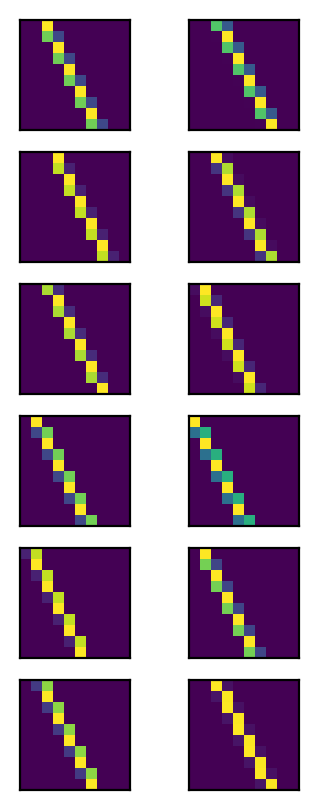

In [95]:
fig, axes = plt.subplots(ncols=n_action, nrows=n_timestep, figsize=(2, 5))
for i in range(n_action):
    for j in range(n_timestep):
        ax = axes[j, i]
        img = transition_p_4d[j, :, i, :]
        ax.imshow(img, aspect=1)
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

## Computing the position transition matrix

In [96]:
n_position = 50
min_position, max_position = 0.0, 1.1
position = np.linspace(min_position, max_position, n_position)
position_list = list(position)
transition_position = np.zeros((n_position, n_velocity, n_position))
for p in position:
    for v in velocity:
        p_idx = position_list.index(p)
        v_idx = velocity_list.index(v)
        for p2 in position:
            p2_idx = position_list.index(p2)
            transition_position[
                p_idx, v_idx, p2_idx
                ] = norm.pdf(p2, loc=p + (1/n_timestep)*v, scale=0.1)
        transition_position[p_idx, v_idx, :] /= transition_position[p_idx, v_idx, :].sum()

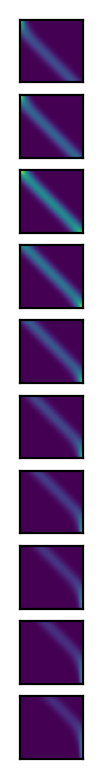

In [97]:
fig, axes = plt.subplots(nrows=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position[:, i, :]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

# Running the environment

In [98]:
all_hist_pos = {}
all_hist_vel = {}

n_sample_run = 20

policies = ["all-one", "all-zero", "random", "max-expected-velocity"]
for policy in policies:

    hist_pos = np.zeros((n_sample_run, n_timestep))
    hist_vel = np.zeros_like(hist_pos)

    for sample in range(n_sample_run):

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        np.random.seed(123 + sample*123)

        for t_idx, t in enumerate(timestep):

            if policy == "all-one":
                a = 1
            elif policy == "all-zero":
                a = 0
            elif policy == "random":
                a = np.random.choice([0, 1])
            elif policy == "max-expected-velocity":
                e_v = np.zeros(2)
                for a in range(2):
                    e_v[a] = np.average(velocity, weights=transition_p_4d[t_idx, v_idx, a, :])
                a = e_v.argmax()
            else:
                raise ValueError

            v_idx = np.random.choice(np.arange(n_velocity), p=transition_p_4d[t_idx, v_idx, a, :]) #= np.average(velocity, weights=p_)
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position[pos_idx, v_idx, :])

            hist_pos[sample, t_idx] = position[pos_idx]
            hist_vel[sample, t_idx] = velocity[v_idx]

        all_hist_pos[policy] = hist_pos
        all_hist_vel[policy] = hist_vel

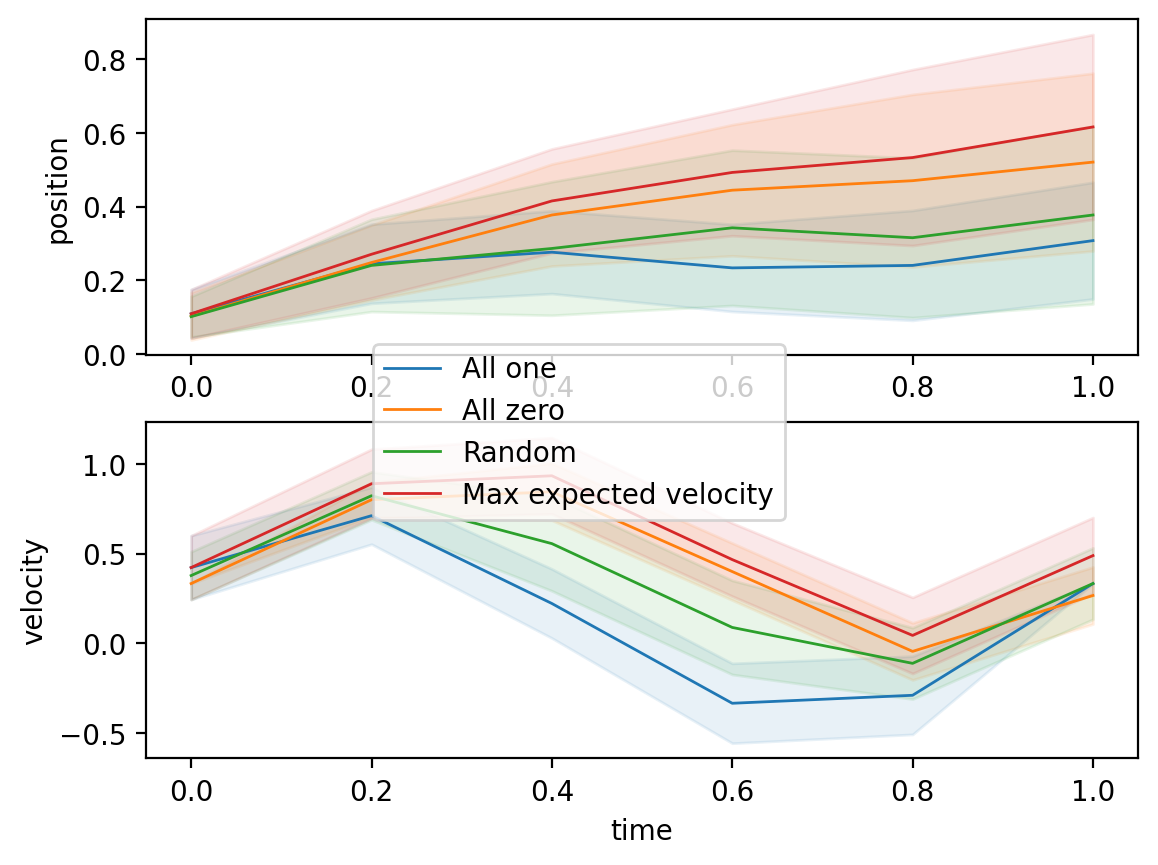

In [99]:
def plot_runs(policies, all_hist_pos, all_hist_vel):
    fig, axes = plt.subplots(nrows=2)
    for i, policy in enumerate(policies):
        label = policy.replace("-", " ").capitalize()
        pos = all_hist_pos[policy].mean(axis=0)
        pos_disp = all_hist_pos[policy].std(axis=0)
        vel = all_hist_vel[policy].mean(axis=0)
        vel_disp = all_hist_vel[policy].std(axis=0)
        x = np.linspace(0, 1, n_timestep)
        if label.startswith("Af"):
            label = label.replace("Af", "Active inference -")
            linewidth = 2
            if label.endswith("epistemic"):
                linestyle = ":"
                linewidth = 4
            elif label.endswith("pragmatic"):
                linestyle = "-."
            else:
                linestyle = "--"
        else:
            linestyle, linewidth = "-", 1
        axes[0].plot(x, pos, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
        axes[0].fill_between(x, pos - pos_disp, pos + pos_disp, alpha=0.1, color=f"C{i}")
        axes[1].plot(x, vel, color=f"C{i}", linestyle=linestyle, linewidth=linewidth)
        axes[1].fill_between(x, vel - vel_disp, vel + vel_disp, alpha=0.1, color=f"C{i}")
        axes[0].set_ylabel("position")
        axes[1].set_ylabel("velocity")
        axes[1].set_xlabel("time")

    fig.legend(loc="center")

plot_runs(policies, all_hist_pos, all_hist_vel)

## Preferences (biased prior on the position)

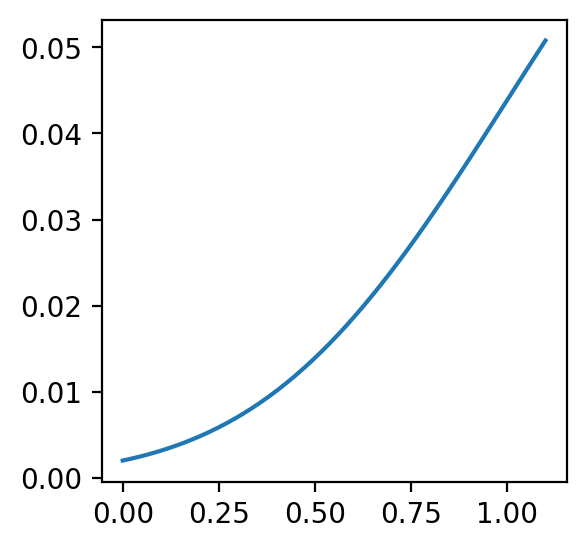

In [100]:
target = 1.0
tolerance = 0.5

y = norm.cdf(position, loc=target, scale=tolerance)
y /= y.sum()

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(position, y);

## Helper functions

In [101]:
def kl_div_dirichlet(alpha, beta):
    """
        https://statproofbook.github.io/P/dir-kl.html
    """
    alpha_0 = np.sum(alpha)
    beta_0 = np.sum(beta)
    kl = (
        gammaln(alpha_0)
        - gammaln(beta_0)
        - np.sum(gammaln(alpha))
        + np.sum(gammaln(beta))
        + np.sum((alpha - beta) * (digamma(alpha) - digamma(alpha_0)))
    )
    return kl

# Pragmatic value

In [102]:
n_timestep

6

In [117]:
horizon = 6

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# Compute log prior
p = norm.cdf(position, loc=target, scale=tolerance)
p /= p.sum()
log_prior = np.log(p)

# For each sample...
for sample in range(1):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin()

    np.random.seed(123 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        val = np.zeros(len(action_plan))
        for ap_index in range(len(action_plan)):

            ap = action_plan[ap_index]

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for i in range(h):
                a = ap[i]
                rollout_t_index = t_idx + i  # For fix horizon => % kdede + think about the reset of position
                qv[:] = qv @ transition_p_4d[rollout_t_index, :, a, :]
                qp = qv @ np.transpose(qp @ np.swapaxes(transition_position, 1, 2)) # p, v, p => p, p, v
                qvs[i] = qv
                qps[i] = qp

            pragmatic = np.sum(qps @ log_prior)
            val[ap_index] = pragmatic

        a = action_plan[np.argmax(val)][0]
        print("h",h, "*" * 20)
        e_v = np.zeros(2)
        for i in range(2):
            e_v[i] = np.average(velocity, weights=transition_p_4d[t_idx, v_idx, i, :])
        print("chosen action", a, "best action", np.argmax(e_v))
        for i in range(2):
            print("a", i, "val", e_v[i])
        print("-"* 20)
        for ap, v in zip(action_plan, val):
            print(ap, v)


        v_idx = np.random.choice(np.arange(n_velocity), p=transition_p_4d[t_idx, v_idx, a, :]) #= np.average(velocity, weights=p_)
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position[pos_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

policy = "af-pragmatic"
if policy not in policies:
    policies.append(policy)
all_hist_pos[policy] = hist_pos
all_hist_vel[policy] = hist_vel


h 6 ********************
chosen action 1 best action 1
a 0 val 0.33333333333333326
a 1 val 0.45777777777777773
--------------------
(0, 0, 0, 0, 0, 0) -3.3008890728041558
(0, 0, 0, 0, 0, 1) -3.2935159625213006
(0, 0, 0, 0, 1, 0) -3.289165723786641
(0, 0, 0, 0, 1, 1) -3.279429494527497
(0, 0, 0, 1, 0, 0) -3.4983720286948614
(0, 0, 0, 1, 0, 1) -3.487699224480836
(0, 0, 0, 1, 1, 0) -3.48563155876378
(0, 0, 0, 1, 1, 1) -3.4766819744797464
(0, 0, 1, 0, 0, 0) -4.0333808782786615
(0, 0, 1, 0, 0, 1) -4.017551933603426
(0, 0, 1, 0, 1, 0) -4.001394937053078
(0, 0, 1, 0, 1, 1) -3.9800398368714416
(0, 0, 1, 1, 0, 0) -4.609447215786979
(0, 0, 1, 1, 0, 1) -4.555559301849934
(0, 0, 1, 1, 1, 0) -4.567311130855666
(0, 0, 1, 1, 1, 1) -4.523968840351344
(0, 1, 0, 0, 0, 0) -3.6187758947528677
(0, 1, 0, 0, 0, 1) -3.609499056464689
(0, 1, 0, 0, 1, 0) -3.6009653140172295
(0, 1, 0, 0, 1, 1) -3.5878553884421542
(0, 1, 0, 1, 0, 0) -3.8847609406235395
(0, 1, 0, 1, 0, 1) -3.8695176030842733
(0, 1, 0, 1, 1, 0) -3.

In [120]:
transition_position.shape, np.swapaxes(transition_position, 1, 2).shape, np.swapaxes(transition_position, 1, 0).shape

((50, 10, 50), (50, 50, 10), (10, 50, 50))

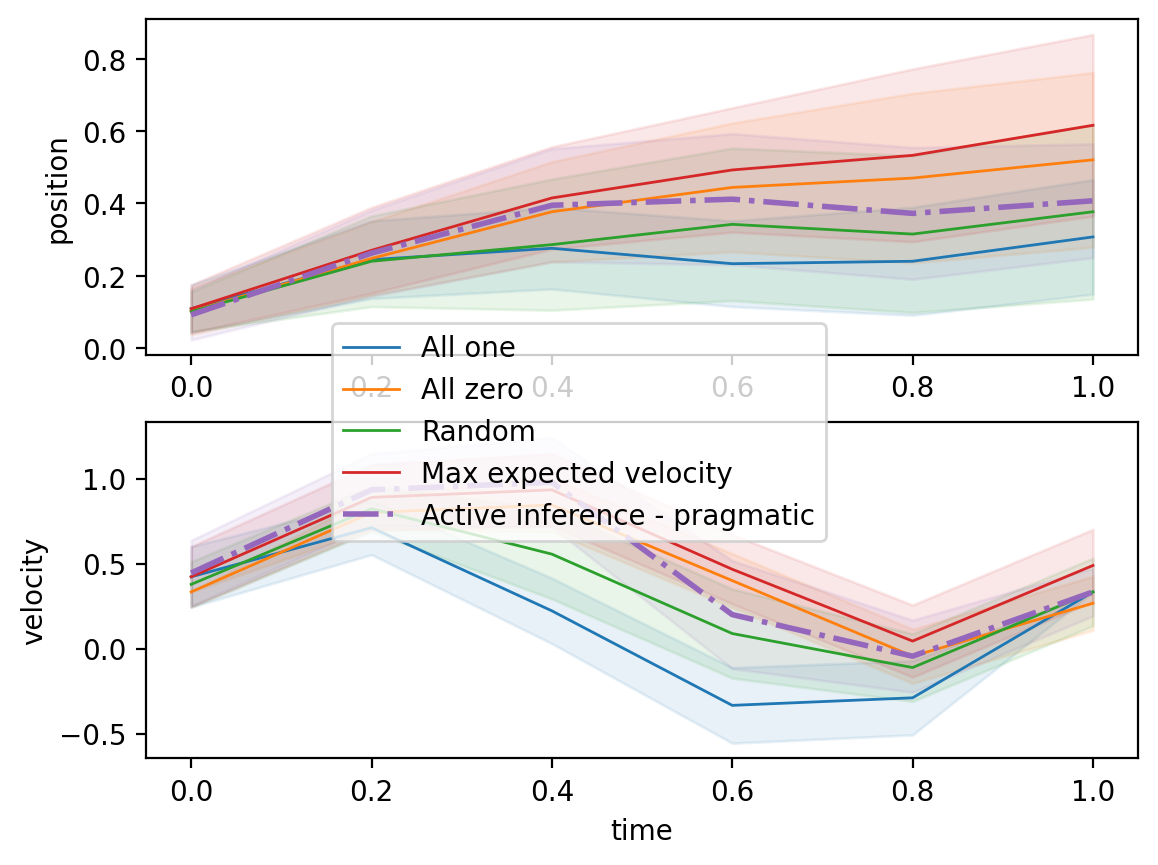

In [106]:
plot_runs(policies, all_hist_pos, all_hist_vel)

In [ ]:
def e_p(alpha_phi):
    sum_col = np.sum(alpha_phi, axis=2)
    sum_col[sum_col <= 0.] = 1
    return alpha_phi / sum_col[:,:,np.newaxis]

In [ ]:
n_episode = 100

alpha_phi = np.zeros((size_space, n_action, n_velocity)) + np.finfo(np.float64).tiny  # Think about "smart" priors (e.g. night)
hist_err = []

print("Initial error", np.sum(np.absolute(p - e_p(alpha_phi))))
hist_err.append(np.sum(np.absolute(p - e_p(alpha_phi))))

epoch = 0
for _ in tqdm(range(n_episode)):
    pos, v = 0, velocity[np.absolute(velocity).argmin()]

    action_plan = np.random.randint(2, size=n_timestep)
    # rn = np.random.randint(3)
    #if rn == 0:
    #    action_plan = np.random.randint(2, size=n_timestep)
    # elif rn == 1:
    #     action_plan = np.ones(n_timestep, dtype=int)
    # elif rn == 2:
    #     action_plan = np.zeros(n_timestep, dtype=int)
    # else:
    #     raise ValueError
    for i, t in enumerate(timestep):

        a = action_plan[i]

        space_index = space.index((v, t))
        v_index = np.random.choice(np.arange(n_velocity), p=p[space_index, a])
        v = velocity[v_index]
        # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
        alpha_phi[space_index,a,v_index] += 1

        # Update velocity
        pos += v

        # Log
        hist_err.append(np.sum(np.absolute(p - e_p(alpha_phi))))
        epoch += 1

print(f"Error after {epoch} epochs", np.sum(np.absolute(p - e_p(alpha_phi))))

In [ ]:
fig, ax = plt.subplots()
ax.plot(hist_err);

In [ ]:
fig, axes = plt.subplots(ncols=2)
for i, ax in enumerate(axes):
    a = i
    img = e_p(alpha_phi)[:, a, :]
    ax.imshow(img, aspect="auto")
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

In [ ]:
n_episode = 100
horizon = 6
n_sample = 10

action_plan = list(itertools.product(range(n_action), repeat=horizon))
n_action_plan = len(action_plan)

alpha_phi = np.zeros((size_space, n_action, n_velocity)) + np.finfo(np.float64).tiny

print("Alpha_phi sum:", alpha_phi.sum())
print("Error before learning:", np.sum(np.absolute(p - e_p(alpha_phi))))


# ---- Pre-train

for k in tqdm(range(0)):
    pos = 0
    v = velocity[np.absolute(velocity).argmin()]
    for i in range(n_timestep):
        t = timestep[i]
        space_index = space.index((v, t))
        a = 0
        v = np.random.choice(velocity, p=p[space_index, a, :])
        # Update alpha_phi
        index_new_v = velocity_list.index(v)
        alpha_phi[space_index, a, index_new_v] += 1

print("Error before learning:", np.sum(np.absolute(p - e_p(alpha_phi))))

hist_err = []
hist_a = []
epoch = 0

with tqdm(total=n_episode) as pbar:
    for _ in range(n_episode):

        pos = 0
        v = velocity[np.absolute(velocity).argmin()]

        for i in range(n_timestep):
            t = timestep[i]
            space_index = space.index((v, t))

            # Initialize action plan values
            val = np.zeros(len(action_plan))

            _ep_ = e_p(alpha_phi)

            # Compute value of each action plan
            for ap_index in range(n_action_plan):
                for _ in range(n_sample):
                    _alpha_phi_ = alpha_phi.copy()
                    v_ = v
                    for j in range(i, min(n_timestep, i + horizon)):
                        t_ = timestep[j]
                        _space_index_ = space.index((v_, t_))
                        a = action_plan[ap_index][j - i]
                        v_index = np.random.choice(np.arange(n_velocity), p=_ep_[_space_index_, a, :])
                        v_ = velocity[v_index]

                        # Keep track of the old beliefs about the transition model
                        beta = _alpha_phi_[_space_index_,a,:].copy()

                        # Update beliefs about the transition model
                        _alpha_phi_[_space_index_,a,v_index] += 1

                        # Keep track of the new beliefs about the transition model
                        alpha = _alpha_phi_[_space_index_,a,:]

                        # Compute KL divergence between the old and new beliefs about the transition model
                        val[ap_index] += kl_div_dirichlet(alpha, beta)

            best_action_plan_index = np.random.choice(np.arange(n_action_plan)[val == val.max()])
            a = action_plan[best_action_plan_index][0]

            v = np.random.choice(velocity, p=p[space_index, a, :])
            pos += v

            # Update alpha_phi
            index_new_v = velocity_list.index(v)
            alpha_phi[space_index, a, index_new_v] += 1

            err = np.sum(np.absolute(p - e_p(alpha_phi)))
            hist_err.append(err)
            hist_a.append(a)
            epoch += 1
        pbar.set_postfix(error=f"{err:.2f}")
        pbar.update(1)

print("Alpha_phi sum:", alpha_phi.sum())

print(f"Error after {epoch} epochs:", np.sum(np.absolute(p - e_p(alpha_phi))))

In [ ]:
hist_a.count(0) / len(hist_a)

In [ ]:
fig, ax = plt.subplots()
ax.plot(hist_err)

In [ ]:
n_episode = 600
horizon = 6
n_sample = 10

hist_err = []
af_hist_vel = []
af_hist_pos = []

action_plan = list(itertools.product(range(n_action), repeat=horizon))

alpha_phi = np.zeros((size_space, n_action, n_velocity)) + np.finfo(np.float64).tiny

print("Alpha_phi sum:", alpha_phi.sum())

print("Error before learning:", np.sum(np.absolute(p - e_p(alpha_phi))))

# # ---- Pre-train
#
# for k in tqdm(range(0)):
#     pos = 0
#     v = velocity[np.absolute(velocity).argmin()]
#     for i in range(n_timestep):
#         t = timestep[i]
#         space_index = space.index((v, t))
#         a = 0
#         v = np.random.choice(velocity, p=p[space_index, a, :])
#         # Update alpha_phi
#         index_new_v = velocity_list.index(v)
#         alpha_phi[space_index, a, index_new_v] += 1
#
# print("Error before learning:", np.sum(np.absolute(p - e_p(alpha_phi))))

hist_a = []

epoch = 0

for k in tqdm(range(n_episode)):
    hist_pos, hist_vel = [], []
    pos = 0
    v = velocity[np.absolute(velocity).argmin()]

    for i in range(n_timestep):
        t = timestep[i]
        space_index = space.index((v, t))

        # Initialize action plan values
        prg_val = np.zeros(len(action_plan))
        eps_val = np.zeros(len(action_plan))

        _ep_ = e_p(alpha_phi)

        # Compute value of each action plan
        for ap_index in range(len(action_plan)):
            for _ in range(n_sample):
                _alpha_phi_ = alpha_phi.copy()
                pos_ = pos
                v_ = v
                for j in range(i, min(n_timestep, i + horizon)):
                    t_ = timestep[j]
                    _space_index_ = space.index((v_, t_))
                    a = action_plan[ap_index][j - i]
                    v_index = np.random.choice(np.arange(n_velocity), p=_ep_[_space_index_, a, :])
                    v_ = velocity[v_index]

                    # Keep track of the old beliefs about the transition model
                    beta = _alpha_phi_[_space_index_,a,:].copy()

                    # Update beliefs about the transition model
                    _alpha_phi_[_space_index_,a,v_index] += 1

                    # Keep track of the new beliefs about the transition model
                    alpha = _alpha_phi_[_space_index_,a,:]

                    # Compute KL divergence between the old and new beliefs about the transition model
                    eps_val[ap_index] += kl_div_dirichlet(alpha, beta)

                    # Compute pragmatic value
                    pos_ += v_
                    prg_val[ap_index] = norm.cdf(pos_, loc=target, scale=tolerance)

                    #print(pos_)

        #print("a0", prg_val[0], eps_val[0])
        #print("a1", prg_val[1], eps_val[1])
        val = prg_val + 0.5*eps_val
        # print("epoch", epoch, "ratio prag/epis", prg_val/eps_val)
        best_overall = action_plan[val.argmax()]
        a = best_overall[0]

        # e_v = np.zeros(2)
        # for action_index in range(n_action):
        #     e_v[action_index] = np.average(velocity, weights=p[space_index, action_index, :])
        # opt_a = e_v.argmax()
        #
        # print("epoch", epoch,  "opt", opt_a, "best_overall", action_plan[val.argmax()][0], "best pragmatic", action_plan[prg_val.argmax()][0], "best epistemic", action_plan[eps_val.argmax()][0])

        v_index = np.random.choice(np.arange(n_velocity), p=p[space_index, a, :])
        v = velocity[v_index]
        pos += v

        # Update alpha_phi
        alpha_phi[space_index, a, v_index] += 1

        # Log
        err = np.sum(np.absolute(p - e_p(alpha_phi)))
        hist_err.append(err)
        hist_pos.append(pos)
        hist_vel.append(v)
        hist_a.append(a)
        epoch += 1

    af_hist_vel.append(hist_vel)
    af_hist_pos.append(hist_pos)

print("Alpha_phi sum:", alpha_phi.sum())

print("Error after learning:", np.sum(np.absolute(p - e_p(alpha_phi))))

In [ ]:
hist_a.count(0) / len(hist_a)

In [ ]:
all_hist_vel["af"] = af_hist_vel[-1]
all_hist_pos["af"] = af_hist_pos[-1]
if "af" not in policies:
    policies.append("af")

In [ ]:
fig, axes = plt.subplots(nrows=2)
for i, policy in enumerate(policies):
    label = policy.replace("-", " ").capitalize()
    pos = all_hist_pos[policy]
    vel = all_hist_vel[policy]
    x = np.linspace(0, 1, n_timestep)
    if label.startswith("Af"):
        label = label.replace("Af", "Active inference -")
        linewidth = 2
        if label.endswith("epistemic"):
            linestyle = ":"
            linewidth = 4
        elif label.endswith("pragmatic"):
            linestyle = "-."
        else:
            linestyle = "--"
    else:
        linestyle, linewidth = "-", 1
    axes[0].plot(x, pos, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
    axes[1].plot(x, vel, color=f"C{i}", linestyle=linestyle, linewidth=linewidth)
    axes[0].set_ylabel("position")
    axes[1].set_ylabel("velocity")
    axes[1].set_xlabel("time")

fig.legend(loc="center");